In [1]:
import time

import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import sys
import errno

from common.camera import *
from common.model import *
from common.loss import *
from common.utils import *
from common.visualization import *
from common.generators import ChunkedGenerator, UnchunkedGenerator
from common.utils import deterministic_random

from scripts.data_preprocessing_human36 import *
from scripts.build_model import *
from scripts.train import *
from scripts.eval import *

In [2]:
dataset_path = "../data/data_3d_h36m.npz"
dataset_path_2d = '../data/data_2d_h36m_cpn_ft_h36m_dbb.npz'

## load data

In [3]:
dataset, keypoints = load_and_preprocess_human36m(dataset_path, dataset_path_2d)

load and process 3d data
load and process 2d data


In [4]:
subjects_train = ['S1', 'S5', 'S6', 'S7', 'S8']
subjects_semi = ['S9']
subjects_test = ['S11']

In [5]:
dataset["S11"].keys()

dict_keys(['Eating 1', 'Photo', 'Walking', 'Greeting 2', 'Walking 1', 'Posing', 'Phoning 3', 'WalkDog', 'Sitting 1', 'Purchases', 'Sitting', 'WalkDog 1', 'Waiting', 'Photo 1', 'SittingDown 1', 'Smoking', 'Greeting', 'Discussion 1', 'Discussion 2', 'WalkTogether', 'Posing 1', 'Eating', 'SittingDown', 'Waiting 1', 'Directions 1', 'Purchases 1', 'WalkTogether 1', 'Phoning 2', 'Smoking 2'])

In [6]:
cameras_valid, poses_valid, poses_valid_2d = fetch(dataset = dataset,
                                                   keypoints = keypoints, 
                                                   subjects = subjects_test, 
                                                   stride = 1)

cameras_train, poses_train, poses_train_2d = fetch(dataset = dataset,
                                                   keypoints = keypoints, 
                                                   subjects = subjects_train, 
                                                   stride = 1)

cameras_semi, _, poses_semi_2d = fetch(dataset = dataset,
                                       keypoints = keypoints,
                                       subjects = subjects_semi,
                                       stride = 1)

## build model

In [7]:
resume = True
gpu_ = False
filter_widths = [3,3,3,3,3]
model_pos_train, model_pos, model_traj, model_traj_train = build_models(17, 2, 17, filter_widths)

if resume:
    chk_filename = "checkpoints/epoch_100.bin"
    print('Loading checkpoint', chk_filename)
    checkpoint = torch.load(chk_filename, map_location=lambda storage, loc: storage)
    print('This model was trained for {} epochs'.format(checkpoint['epoch']))
    model_pos_train.load_state_dict(checkpoint['model_pos'])
    model_pos.load_state_dict(checkpoint['model_pos'])
    model_traj_train.load_state_dict(checkpoint['model_traj'])
    model_traj.load_state_dict(checkpoint['model_traj'])
    

# load model on gpu
if torch.cuda.is_available():
    model_pos = model_pos.cuda()
    model_pos_train = model_pos_train.cuda()
    model_traj = model_traj.cuda()
    model_traj_train = model_traj_train.cuda()

# copy on multi-gpu
devices = [0, 1, 2]
model_pos_train = nn.DataParallel(model_pos_train, device_ids=devices)
model_traj_train = nn.DataParallel(model_traj_train, device_ids=devices)

models = {}
models["model_pos_train"] = model_pos_train
models["model_pos"] = model_pos
models["model_traj_train"] = model_traj_train
models["model_traj"] = model_traj

Loading checkpoint checkpoints/epoch_100.bin
This model was trained for 100 epochs


## build data generator

In [8]:
receptive_field = model_pos.receptive_field()
pad = (receptive_field - 1) // 2
batch_size = 4096*2

In [9]:
test_generator = UnchunkedGenerator(cameras_valid, poses_valid, poses_valid_2d, pad=pad, causal_shift=0, augment=False)
train_generator = ChunkedGenerator(batch_size, cameras_train, poses_train, poses_train_2d, 1, pad=pad, causal_shift=0, shuffle=True, augment=False)
train_generator_eval = UnchunkedGenerator(cameras_train, poses_train, poses_train_2d, pad=pad, causal_shift=0, augment=False)
semi_generator = ChunkedGenerator(batch_size, cameras_semi, None, poses_semi_2d, 1, pad=pad, causal_shift=0, shuffle=True, random_seed=4321, augment=False, endless=True)
semi_generator_eval = UnchunkedGenerator(cameras_semi, None, poses_semi_2d, pad=pad, causal_shift=0, augment=False)

if resume:
    train_generator.set_random_state(checkpoint['random_state'])
    semi_generator.set_random_state(checkpoint['random_state_semi'])

generators = {}
generators["test_generator"] = test_generator
generators["train_generator"] = train_generator
generators["train_generator_eval"] = train_generator_eval
generators["semi_generator"] = semi_generator
generators["semi_generator_eval"] = semi_generator_eval

## Optimizer Meta

In [10]:
lr = 0.001
initial_momentum = 0.1
final_momentum = 0.001
lr_decay = 0.95
optimizer = optim.Adam(list(model_pos_train.parameters()) + list(model_traj_train.parameters()),
                               lr=lr, amsgrad=True)
if resume:
    optimizer.load_state_dict(checkpoint['optimizer'])
    lr = checkpoint["lr"]

## Loss

In [11]:
losses = Losses()

## Training Meta

In [12]:
checkpoint_folder = "checkpoints/"
save_freq = 10 
warmup = 5
epochs = 100

if resume:
    start_epoch = checkpoint['epoch']
else:
    start_epoch = 0

## Training Loop

In [13]:
for epoch in range(start_epoch, epochs+1):
    if epoch < warmup:
        skip = True
    else:
        skip = False
        
    models, optimizer, train_losses = train(models, generators, optimizer, pad, skip, False, True, epoch)    
    eval_losses = evaluate(models, generators, pad)
    losses.update(train_losses, eval_losses)    
    
    # Decay learning rate exponentially
    lr *= lr_decay
    for param_group in optimizer.param_groups:
        param_group['lr'] *= lr_decay

    # Decay BatchNorm momentum
    momentum = initial_momentum * np.exp(-epoch/epochs * np.log(initial_momentum/final_momentum))
    models["model_pos_train"].module.expand_bn.momentum = momentum
    models["model_traj_train"].module.expand_bn.momentum = momentum
    # print(" -- epoch {:3d} -- ".format(i))
    
    if epoch % save_freq == 0:
        chk_path = os.path.join(checkpoint_folder, 'epoch_{}.bin'.format(epoch))
        print('Saving checkpoint to', chk_path)
        torch.save({
                'epoch': epoch,
                'lr': lr,
                'random_state': generators["train_generator"].random_state(),
                'optimizer': optimizer.state_dict(),
                'model_pos': states_convert(models["model_pos_train"]),
                'model_traj': states_convert(models["model_traj_train"]),
                'random_state_semi': generators["semi_generator"].random_state(),
            }, chk_path)

 evaluate on unlabel train set : 100%|██████████| 120/120 [00:02<00:00, 50.15it/s]


Saving checkpoint to checkpoints/epoch_0.bin


 evaluate on unlabel train set : 100%|██████████| 120/120 [00:02<00:00, 51.19it/s]


Saving checkpoint to checkpoints/epoch_10.bin


 evaluate on unlabel train set : 100%|██████████| 120/120 [00:02<00:00, 51.10it/s]


Saving checkpoint to checkpoints/epoch_20.bin


 evaluate on unlabel train set : 100%|██████████| 120/120 [00:02<00:00, 51.28it/s]


Saving checkpoint to checkpoints/epoch_30.bin


 evaluate on unlabel train set : 100%|██████████| 120/120 [00:02<00:00, 51.12it/s]


Saving checkpoint to checkpoints/epoch_40.bin


 evaluate on unlabel train set : 100%|██████████| 120/120 [00:02<00:00, 51.18it/s]


Saving checkpoint to checkpoints/epoch_50.bin


 evaluate on unlabel train set : 100%|██████████| 120/120 [00:02<00:00, 51.15it/s]


Saving checkpoint to checkpoints/epoch_60.bin


 evaluate on unlabel train set : 100%|██████████| 120/120 [00:02<00:00, 51.18it/s]


Saving checkpoint to checkpoints/epoch_70.bin


 evaluate on unlabel train set : 100%|██████████| 120/120 [00:02<00:00, 51.23it/s]


Saving checkpoint to checkpoints/epoch_80.bin


 evaluate on unlabel train set : 100%|██████████| 120/120 [00:02<00:00, 49.73it/s]


Saving checkpoint to checkpoints/epoch_90.bin


 evaluate on unlabel train set : 100%|██████████| 120/120 [00:02<00:00, 51.27it/s]


Saving checkpoint to checkpoints/epoch_100.bin


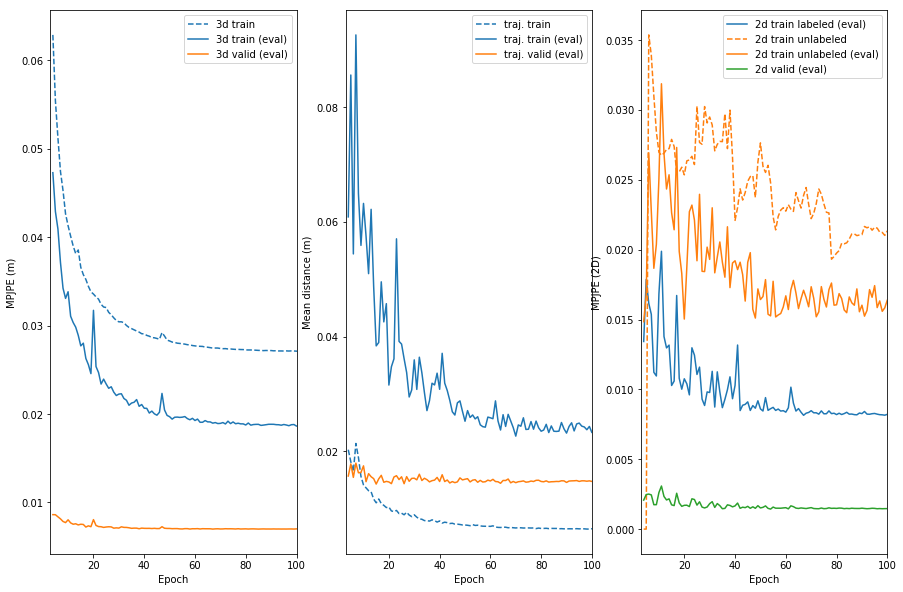

In [14]:
fig = losses.visualize(start_epoch, epoch)